## LOAD DATA

In [1]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import matplotlib.pyplot as plt

# Load the merged CSV file
file_path = 'cleaned_state_action_10000.csv'
df = pd.read_csv(file_path)

# Separate the features (states) and target (actions)
state_columns = [col for col in df.columns if col.startswith('State')]
action_columns = [col for col in df.columns if col.startswith('Action')]

X = df[state_columns]
y = df[action_columns]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



c:\Users\Ale\anaconda3\envs\business\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## RANDOM FOREST

In [2]:

# Train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Improve the model
# Tune the hyperparameters of the Random Forest model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Define the hyperparameters
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best_rf = best_rf_model.predict(X_test)
print("Best Random Forest Regression Report:")
print("MSE:", mean_squared_error(y_test, y_pred_best_rf))



Fitting 3 folds for each of 81 candidates, totalling 243 fits


## SHAP

SHAP Values Shape:
(100, 24, 6)


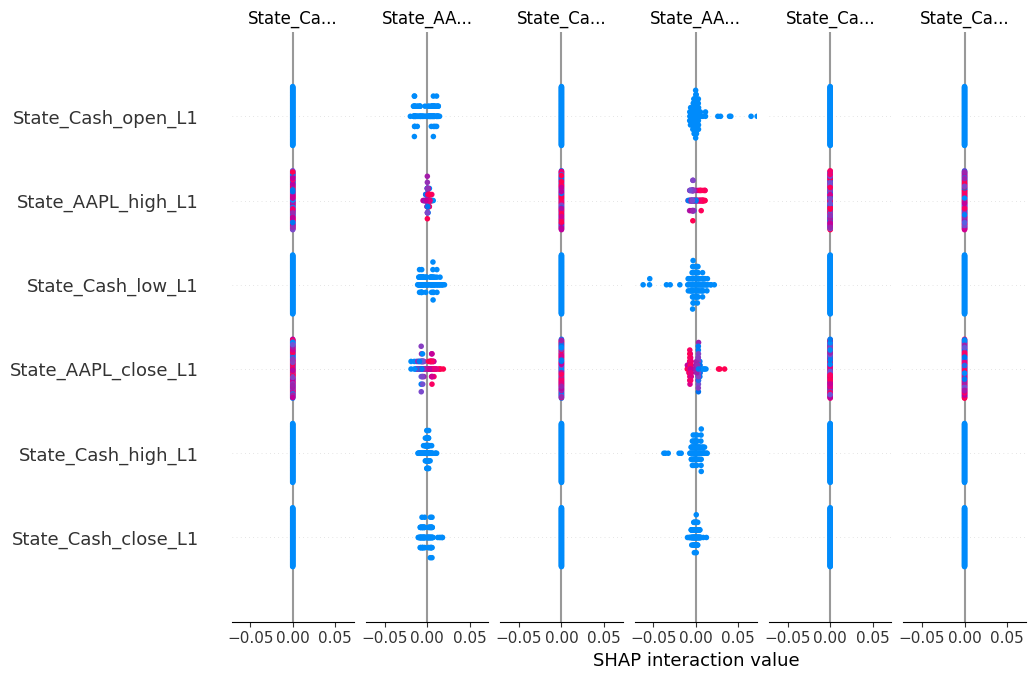

In [3]:
explainer = shap.TreeExplainer(best_rf_model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# print shap_values shape
print("SHAP Values Shape:")
print(shap_values.shape)

# Plot the SHAP values
shap.summary_plot(shap_values, X_test)
plt.show()



In [9]:
shap.plots.force(explainer.expected_value[0], shap_values[..., 0])

In [17]:

# Detailed explanation for a single prediction
sample_index = 0

# shap feauture names
shap.initjs()
shap.plots.force(explainer.expected_value[sample_index], shap_values[..., sample_index],feature_names=X_test.columns, link='logit')

In [ ]:

# Save in HTML
shap.save_html("shap.html", shap.plots.force(explainer.expected_value[sample_index], shap_values[..., sample_index],feature_names=X_test.columns, link='logit'))





In [ ]:

# Save the plot in html format
shap.save_html("shap_plot.html", shap.plots.force(explainer.expected_value[sample_index], shap_values[..., sample_index],feature_names=X_test.columns, link='logit'))



## LIME

In [6]:
import lime
import lime.lime_tabular

# Explain predictions using LIME
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode='regression', feature_names=X_train.columns.tolist(), discretize_continuous=False)

# Explain the first sample as detailed as possible
sample_index = 0
exp = explainer.explain_instance(X_test.values[sample_index], best_rf_model.predict, num_features=5)
exp.show_in_notebook(show_table=True)



c:\Users\Ale\anaconda3\envs\business\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Feature Importance

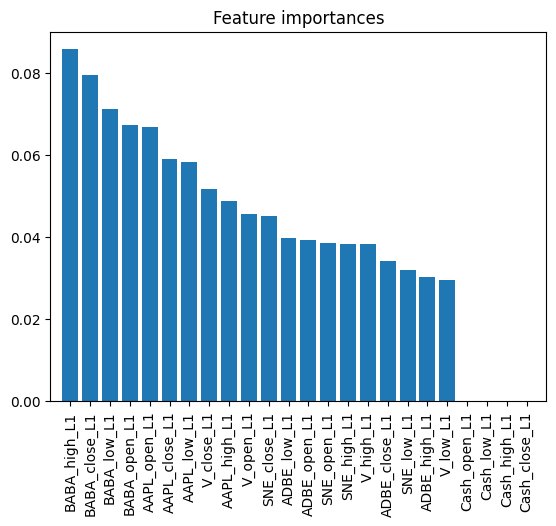

In [91]:
import numpy as np

# Feature importance
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Columns names
columns = X_train.columns
# Delete words 'State_' from columns names
columns = [col[6:] for col in columns]


# Plot the feature importances 
plt.figure()
plt.size = (200, 400)
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), np.array(columns)[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


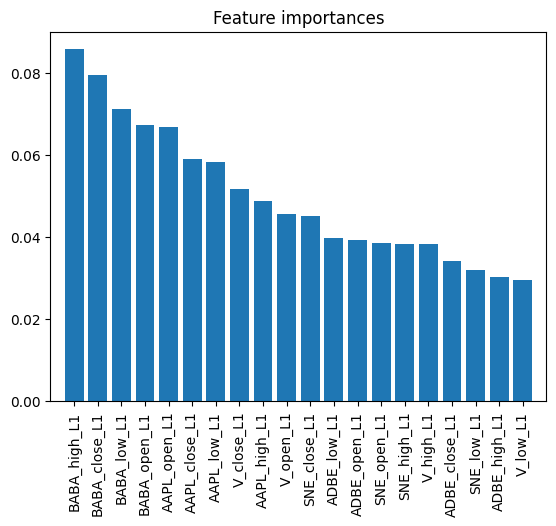

In [92]:

# Delete colums with zero importance
columns = np.array(columns)[indices]
importances = importances[indices]
columns = columns[importances > 0]
importances = importances[importances > 0]

# Plot the feature importances
plt.figure()
plt.size = (200, 400)
plt.title("Feature importances")
plt.bar(range(len(columns)), importances, align="center")
plt.xticks(range(len(columns)), columns, rotation=90)
plt.xlim([-1, len(columns)])
plt.show()


In [93]:
#Treshold=median of importances
threshold= np.median(importances)

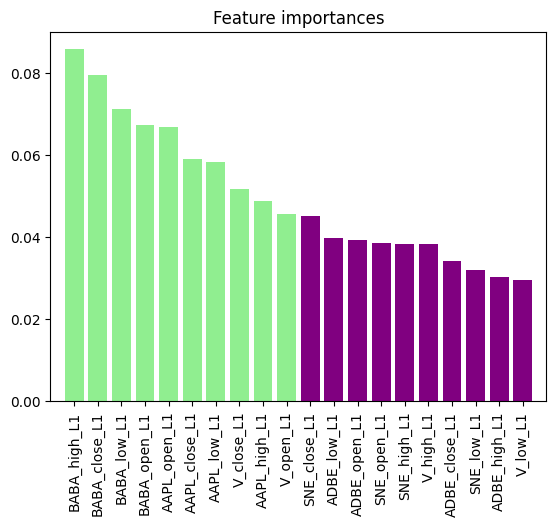

In [94]:

# Different colors for different importance levels
colors = ['lightgreen' if imp > threshold else 'purple' for imp in importances]

# Plot the feature importances
plt.figure()
plt.size = (200, 400)
plt.title("Feature importances")
plt.bar(range(len(columns)), importances, align="center", color=colors)
plt.xticks(range(len(columns)), columns, rotation=90)
plt.xlim([-1, len(columns)])
plt.show()


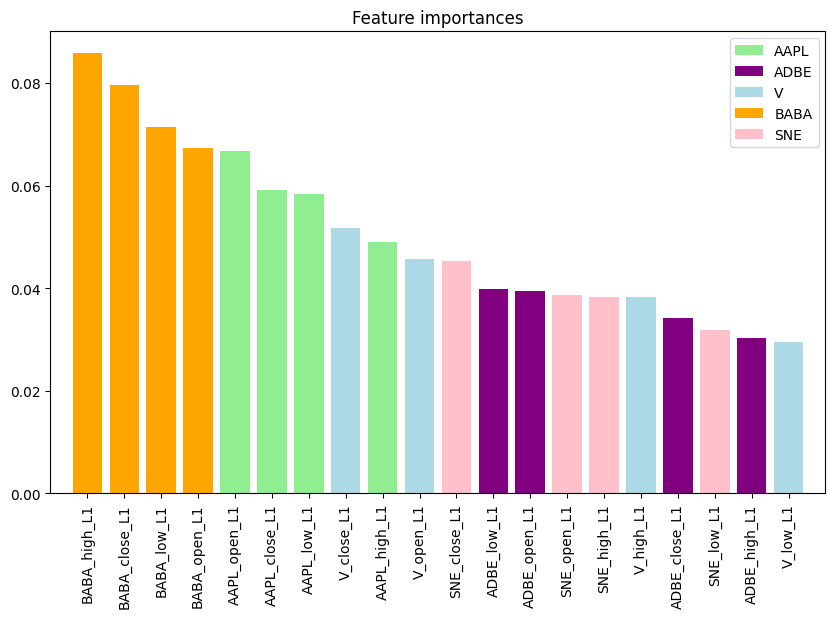

In [95]:

# Read tickers in data
# From columns take only tickers (first word before '_')
tickers = [col.split('_')[0] for col in columns]
# Get unique tickers
tickers = list(set(tickers))

# Create a list of colors for each ticker
colors = ['lightgreen', 'purple', 'lightblue', 'orange', 'pink', 'yellow', 'red', 'blue', 'green', 'brown', 'black', 'grey', 'cyan', 'magenta', 'olive', 'navy', 'lime', 'teal', 'aqua', 'maroon', 'fuchsia', 'purple', 'silver', 'gray', 'white']

# Create a dictionary with tickers as keys and colors as values
ticker_colors = dict(zip(tickers, colors))

# Plot the feature importances with different colors for each ticker
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
bars = plt.bar(range(len(columns)), importances, align="center", color=[ticker_colors[col.split('_')[0]] for col in columns])

# Create a proxy artist for the legend
from matplotlib.patches import Patch
legend_elements_tickers = [Patch(facecolor=ticker_colors[ticker], label=ticker) for ticker in tickers]

plt.legend(handles=legend_elements_tickers, loc='upper right')
plt.xticks(range(len(columns)), columns, rotation=90)
plt.xlim([-1, len(columns)])
plt.show()



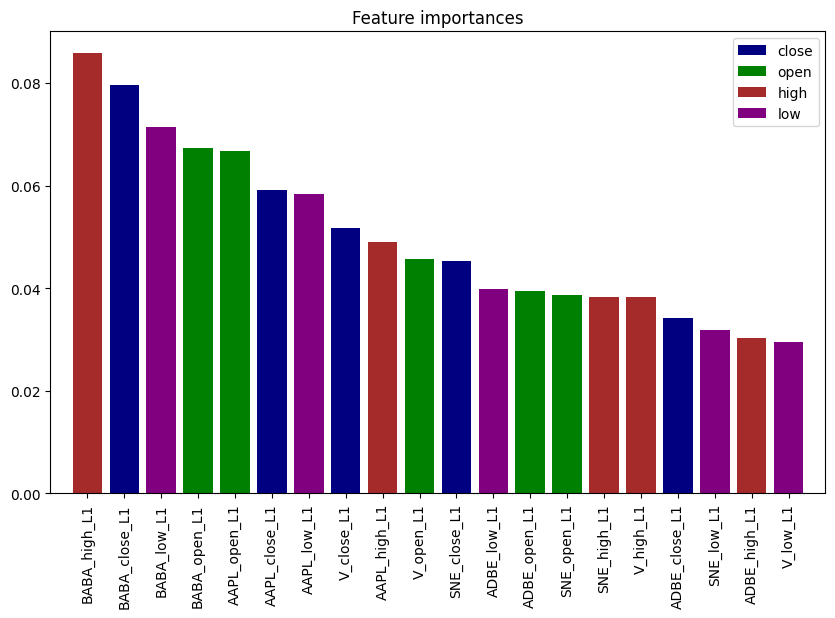

In [96]:
# Different colors for different values (close, open, high, low)
colors = ['navy', 'green', 'brown', 'purple']

# Create a dictionary with values as keys and colors as values
value_colors = dict(zip(['close', 'open', 'high', 'low'], colors))

# Plot the feature importances with different colors for each value
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
bars = plt.bar(range(len(columns)), importances, align="center", color=[value_colors[col.split('_')[1]] for col in columns])

# Create a proxy artist for the legend
legend_elements_values = [Patch(facecolor=value_colors[value], label=value) for value in ['close', 'open', 'high', 'low']]
plt.legend(handles=legend_elements_values, loc='upper right')
plt.xticks(range(len(columns)), columns, rotation=90)
plt.xlim([-1, len(columns)])
plt.show()

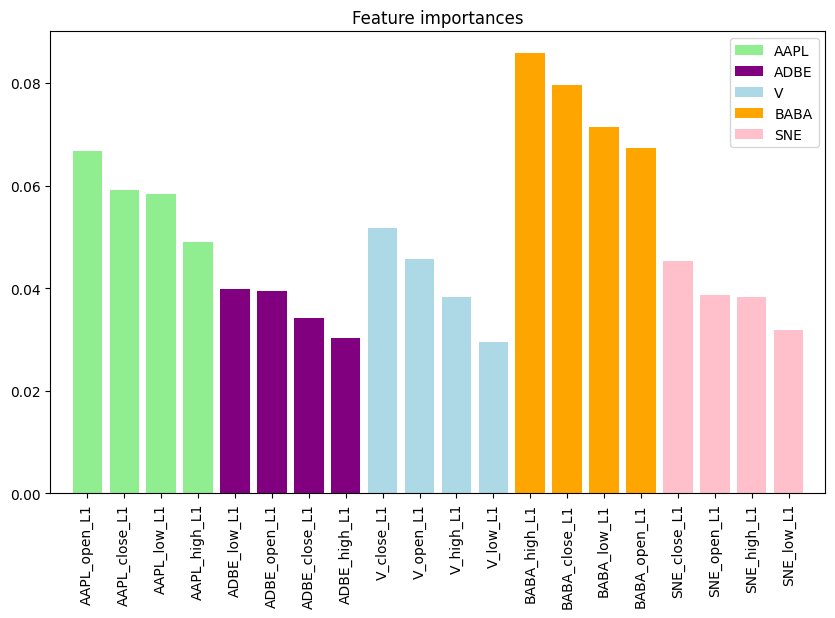

In [97]:
# Sort the feature importances by ticker
columns = np.array(columns)
importances = np.array(importances)
tickers = [col.split('_')[0] for col in columns]
tickers = list(set(tickers))
columns_sorted = []
importances_sorted = []
for ticker in tickers:
    mask = [ticker in col for col in columns]
    columns_sorted.extend(columns[mask])
    importances_sorted.extend(importances[mask])

# Plot the feature importances sorted by ticker
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
bars = plt.bar(range(len(columns_sorted)), importances_sorted, align="center", color=[ticker_colors[col.split('_')[0]] for col in columns_sorted])
plt.legend(handles=legend_elements_tickers, loc='upper right')
plt.xticks(range(len(columns_sorted)), columns_sorted, rotation=90)
plt.xlim([-1, len(columns_sorted)])
plt.show()

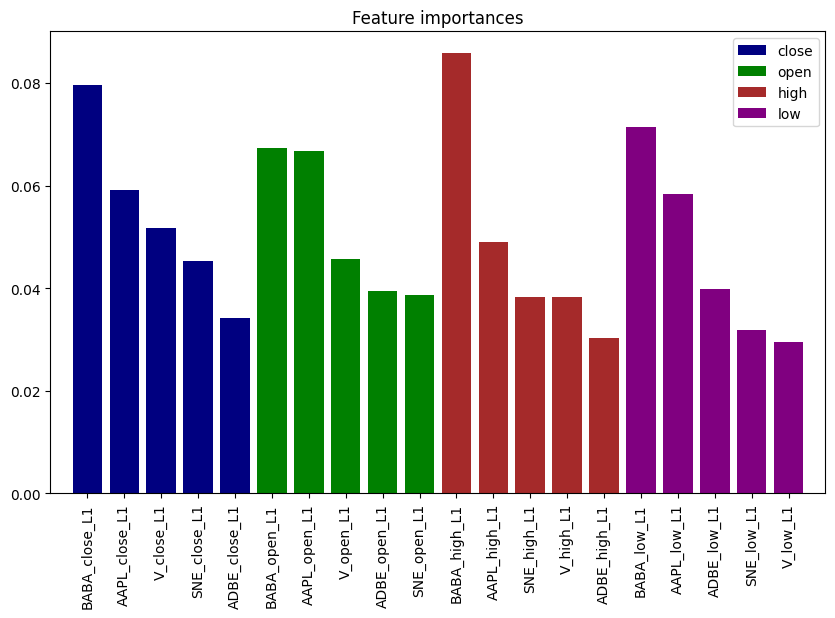

In [98]:
# Sort the feature importances by value (close, open, high, low)
columns_sorted = []
importances_sorted = []
for value in ['close', 'open', 'high', 'low']:
    mask = [value in col for col in columns]
    columns_sorted.extend(columns[mask])
    importances_sorted.extend(importances[mask])

# Plot the feature importances sorted by value
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
bars = plt.bar(range(len(columns_sorted)), importances_sorted, align="center", color=[value_colors[col.split('_')[1]] for col in columns_sorted])
plt.legend(handles=legend_elements_values, loc='upper right')
plt.xticks(range(len(columns_sorted)), columns_sorted, rotation=90)
plt.xlim([-1, len(columns_sorted)])
plt.show()

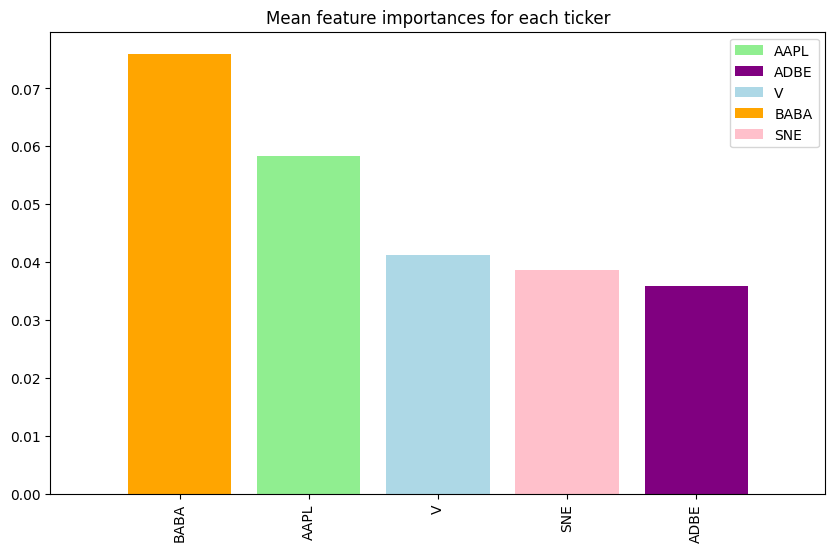

In [99]:
# Plit the mean importances for each ticker
mean_importances = []
for ticker in tickers:
    mask = [ticker in col for col in columns]
    mean_importances.append(np.mean(importances[mask]))

# Sort the mean importances
indices = np.argsort(mean_importances)[::-1]
tickers_sorted = np.array(tickers)[indices]
mean_importances_sorted = np.array(mean_importances)[indices]

# Plot the mean importances for each ticker
plt.figure(figsize=(10, 6))
plt.title("Mean feature importances for each ticker")
bars = plt.bar(range(len(tickers_sorted)), mean_importances_sorted, align="center", color=[ticker_colors[ticker] for ticker in tickers_sorted])
plt.legend(handles=legend_elements_tickers, loc='upper right')
plt.xticks(range(len(tickers_sorted)), tickers_sorted, rotation=90)
plt.xlim([-1, len(tickers_sorted)])
plt.show()


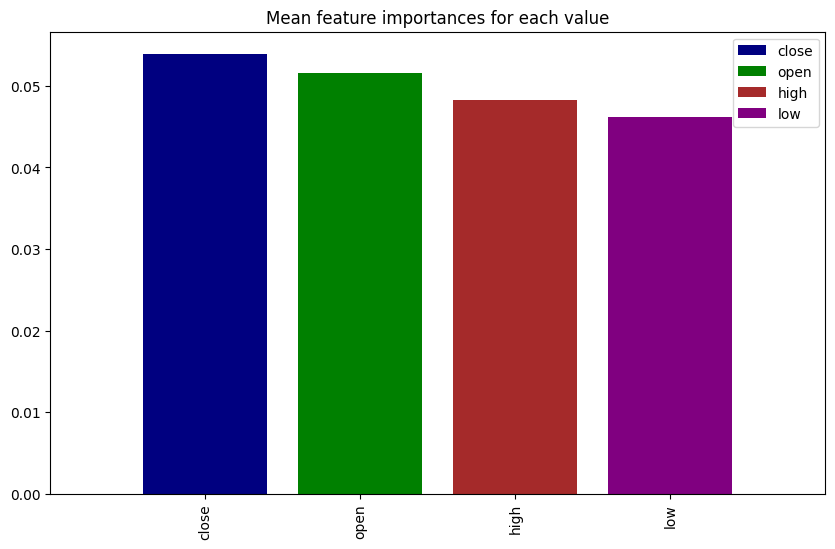

In [100]:
# Plot the mean importances for each value
mean_importances = []
for value in ['close', 'open', 'high', 'low']:
    mask = [value in col for col in columns]
    mean_importances.append(np.mean(importances[mask]))

# Sort the mean importances
indices = np.argsort(mean_importances)[::-1]
values_sorted = ['close', 'open', 'high', 'low']
values_sorted = np.array(values_sorted)[indices]
mean_importances_sorted = np.array(mean_importances)[indices]

# Plot the mean importances for each value
plt.figure(figsize=(10, 6))
plt.title("Mean feature importances for each value")
bars = plt.bar(range(len(values_sorted)), mean_importances_sorted, align="center", color=[value_colors[value] for value in values_sorted])
plt.legend(handles=legend_elements_values, loc='upper right')
plt.xticks(range(len(values_sorted)), values_sorted, rotation=90)
plt.xlim([-1, len(values_sorted)])
plt.show()